Predicting UP IR flux on all layers, using all the layers now

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
DS_a = xr.open_dataset('af') #dataset of auxhist
DS_w = xr.open_dataset('wf') #dataset of wrfout

In [3]:
#Temperature:
T = (DS_w.T.values + DS_w.T0) * ((DS_w.P.values + DS_w.PB.values)/DS_w.P0)**(DS_w.R_D/DS_w.CP)
T.shape

(71, 52, 36, 72)

In [4]:
T[5,:,18,0] #temperature goes from lowest hieght to highest hieght

array([242.71082 , 237.8069  , 236.24007 , 235.12848 , 234.2799  ,
       233.52779 , 232.82172 , 232.14073 , 231.47406 , 230.81564 ,
       229.99742 , 229.01949 , 228.03973 , 227.05513 , 225.73048 ,
       224.05423 , 220.9039  , 215.62561 , 209.97517 , 208.85222 ,
       206.90262 , 204.41917 , 200.12592 , 195.17355 , 189.94121 ,
       186.28903 , 183.58492 , 180.31416 , 176.13753 , 171.68274 ,
       167.32304 , 163.81029 , 160.24342 , 155.59138 , 150.58986 ,
       146.3529  , 142.94057 , 139.79279 , 136.59853 , 133.4877  ,
       131.82347 , 138.27815 , 160.04852 , 173.36342 , 169.7645  ,
       162.5508  , 155.04514 , 147.05397 , 139.96574 , 138.28108 ,
       119.210464, 138.57014 ], dtype=float32)

In [5]:
st = DS_w.TSK.values #surface temp
st.shape

(71, 36, 72)

In [6]:
d_c = DS_w.TAU_OD.values #dust optical depth
d_c.shape 

(71, 52, 36, 72)

In [7]:
d_c2 = DS_w.TAU_OD2D.values
d_c2.shape

(71, 36, 72)

In [8]:
em = DS_w.EMISS.values #emissivity
em.shape 

(71, 36, 72)

In [9]:
uif = DS_a.UPIRFLUX.values[1:,:,:,:] #look at up visual flux after 1st time snapshot
uif[:,1,:,:].reshape(-1).shape

(181440,)

In [10]:
uif[:,1,:,:].shape

(70, 36, 72)

In [11]:
temp_uif = []
for i in range(52):
    temp_uif.append(uif[:,i,:,:].reshape(-1))
uif = np.array(temp_uif).T
uif.shape

(181440, 52)

In [12]:
sla = [] #special layer arrays that are the feature vectors in the linear regression model
sla.append((em*st**4).reshape(-1)) #don't have overall opacity, will deal with this issue later
for i in range(52): #using all the layers now
    sla.append((np.exp(-d_c[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
sla = np.array(sla)
sla = sla.T[2592:,:] #take transpose, remove first day of data (all lwr are 0 there)


In [13]:
sla.shape

(181440, 53)

# Trying linear regression first

In [14]:
from sklearn.linear_model import LinearRegression
uif_out = uif
lr1 = LinearRegression()
lr1.fit(sla,uif_out)
uif_lin = lr1.predict(sla) #predicted

In [15]:
lr1.coef_

array([[ 3.2619688e-08,  3.9561286e-08, -2.1152733e-08, ...,
         5.8138383e-09, -5.0953952e-09,  3.2038514e-09],
       [ 3.2619699e-08,  3.9561161e-08, -2.1152697e-08, ...,
         5.8140515e-09, -5.0956483e-09,  3.2035103e-09],
       [ 3.2619713e-08,  3.9561034e-08, -2.1152633e-08, ...,
         5.8141509e-09, -5.0958642e-09,  3.2031977e-09],
       ...,
       [ 4.0894953e-08,  2.5016998e-08, -9.1155918e-09, ...,
         1.4005039e-08, -1.1064600e-08,  7.2029849e-09],
       [ 4.1195946e-08,  2.5418810e-08, -9.1853121e-09, ...,
         1.4139502e-08, -1.1177558e-08,  7.4946058e-09],
       [ 4.1598369e-08,  2.6165194e-08, -8.9638199e-09, ...,
         1.4301541e-08, -1.1325945e-08,  7.8907476e-09]], dtype=float32)

In [16]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

7.3685

In [17]:
np.min(uif_out)

15.631578

In [18]:
np.max(uif_out)

484.69852

In [19]:
uif_diff = (uif_out - uif_lin).reshape(-1)

In [20]:
np.min(uif_diff)

-41.411087

In [21]:
np.max(uif_diff)

100.696075

In [22]:
uif_diff.shape

(9434880,)

In [23]:
np.where(uif_diff > 50)

(array([ 213876,  213877,  213878, ..., 9379237, 9379238, 9379239],
       dtype=int64),)

<function matplotlib.pyplot.show(*args, **kw)>

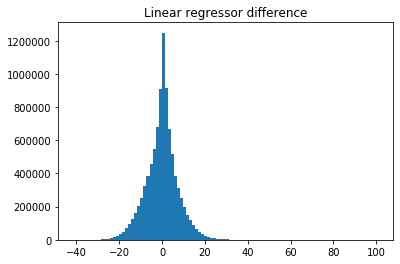

In [24]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [25]:
uif_out.reshape(-1,1).shape

(9434880, 1)

In [26]:
uif_lin[:,1].shape

(181440,)

In [27]:
sla[:10*36*72,:].shape

(25920, 53)

In [28]:
sla[10*36*72:11*36*72,:].shape

(2592, 53)

In [29]:
real_out = uif_out[10*36*72:11*36*72, 10].reshape(36,72) #let's plot 10th layer
pred_out = uif_lin[10*36*72:11*36*72, 10].reshape(36,72)

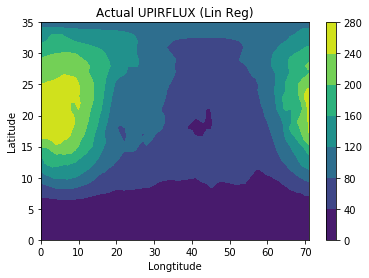

In [30]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

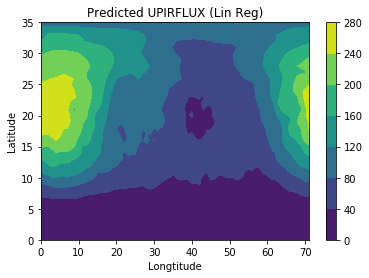

In [31]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

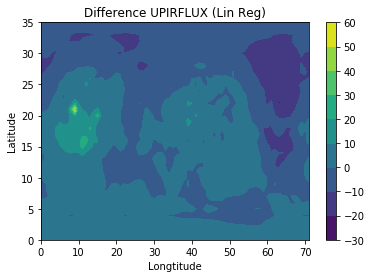

In [32]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

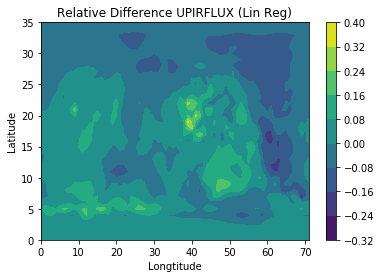

In [33]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

In [34]:
real_out = uif_out[10*36*72 + 18*72:10*36*72 + 19*72, :].T #let's plot equator on 11th day
pred_out = uif_lin[10*36*72 + 18*72:10*36*72 + 19*72, :].T

In [35]:
uif_out[10*36*72 + 18*72:10*36*72 + 19*72, :].shape

(72, 52)

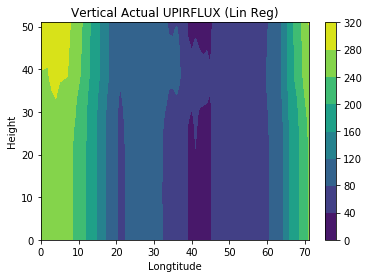

In [36]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Vertical Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Height")
plt.show()

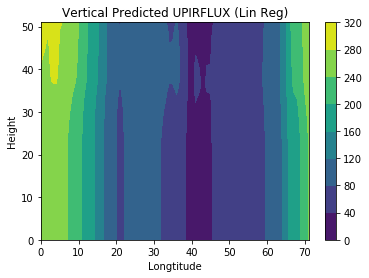

In [37]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Vertical Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Height")
plt.show()

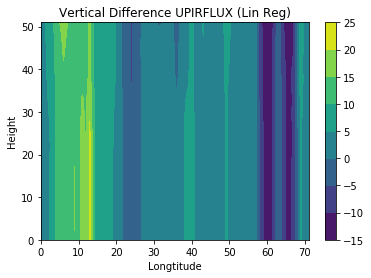

In [38]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Vertical Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Height")
plt.show()

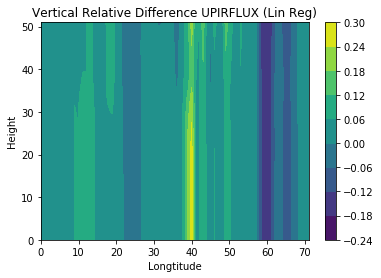

In [39]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Vertical Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Height")
plt.show()

In [40]:
uif_out[:10*36*72].shape

(25920, 52)

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [41]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [42]:
real_out.shape

(52, 72)

Integrals for 10th layer:

In [43]:
lin_int_err = int_err(uif_lin[10*36*72:11*36*72,10], uif_out[10*36*72:11*36*72,10], pd.DataFrame(uif_lin), 3.39e6) #make sure the errors work by integrating a sphere's surface
print("Linear regression integration error:")
lin_int_err/(1.44e14) #also smaller than when just using the 10 layers

Linear regression integration error:


-0.6345342010345507

Integrals for all layers, for all times:

In [53]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52):
    #lin_int_err = int_err(uif_lin[:,i], uif_out[:,i], pd.DataFrame(uif_lin), 3.39e6) 
    #lin_t_int.append(lin_int_err/1.44e14/70) 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) #make sure the errors work by integrating a sphere's surface
        lin_errors.append(lin_int_err/(1.44e14)) #reasonably large
    lin_t_int.append(lin_errors)

In [54]:
np.array(lin_t_int).shape #errors from linear regressor for all layers, all snapshots

(52, 70)

In [55]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([4.85714324, 4.85694216, 4.85699039, 4.85677055, 4.85645705,
       4.85641514, 4.85653612, 4.85694281, 4.85706968, 4.85713972,
       4.85729728, 4.85768637, 4.85808844, 4.85872857, 4.86056984,
       4.86569181, 4.87486108, 4.88787022, 4.90365342, 4.9215491 ,
       4.94154299, 4.96615632, 4.99716763, 5.03687114, 5.08571893,
       5.14579171, 5.21992399, 5.31072816, 5.42051525, 5.55176403,
       5.70782367, 5.88056774, 6.06149968, 6.24643838, 6.42985882,
       6.60602911, 6.76095597, 6.88478537, 6.94981943, 6.96164683,
       6.96441303, 6.96229648, 6.95661094, 6.94574578, 6.92679286,
       6.90892646, 6.88598355, 6.85738501, 6.82441337, 6.78463047,
       6.7324273 , 6.65963956])

In [56]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([-1.00144699, -1.00158174, -1.00146179, -1.00141447, -1.00156611,
       -1.00144188, -1.00151404, -1.00163423, -1.00150669, -1.00140161,
       -1.00123501, -1.00077898, -1.00036247, -1.0001062 , -1.00048116,
       -1.00144541, -1.00294162, -1.00579954, -1.01116843, -1.01905383,
       -1.02891516, -1.04115235, -1.05459328, -1.06982823, -1.08670221,
       -1.10591193, -1.12693594, -1.15089127, -1.18265454, -1.22048224,
       -1.26308146, -1.31042708, -1.36775769, -1.43647152, -1.50734962,
       -1.58007921, -1.66428122, -1.73932675, -1.79418992, -1.81311348,
       -1.82975499, -1.83850273, -1.8464582 , -1.85261558, -1.85652906,
       -1.85767722, -1.85717883, -1.85511331, -1.85047841, -1.8463845 ,
       -1.83943349, -1.8264601 ])

In [58]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([1.52828399, 1.52827445, 1.52825248, 1.52821581, 1.52823926,
       1.52826293, 1.52827015, 1.5283452 , 1.5282251 , 1.52808358,
       1.52791568, 1.52764665, 1.52733867, 1.52731909, 1.52791472,
       1.52951839, 1.53221466, 1.53644159, 1.54249054, 1.55043477,
       1.56017853, 1.57221777, 1.58579443, 1.60066049, 1.61688845,
       1.63471624, 1.65487444, 1.67945325, 1.71029571, 1.74755423,
       1.792296  , 1.84437657, 1.90233243, 1.96485416, 2.0278983 ,
       2.08914616, 2.14598446, 2.19508118, 2.22560417, 2.23400915,
       2.24027082, 2.24303859, 2.24478355, 2.24502573, 2.24310086,
       2.2404978 , 2.23663605, 2.23128921, 2.22440018, 2.21541648,
       2.20300521, 2.18500932])

All the errors have the same sign...Let's look at the averages:

In [48]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
0.5354717060781776


All the layers have pretty similar behaviour in terms of predictive ability.